Step 1: Import library

In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


# ==========================
# Data & basic tools
# ==========================
import pandas as pd
import numpy as np

# ==========================
# Visualization
# ==========================
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# Statistical analysis
# ==========================
from scipy.stats import (
    ttest_ind, 
    levene, 
    chi2_contingency, 
    skew, 
    kurtosis, 
    pearsonr, 
    f_oneway
)
import statsmodels.api as sm

# ==========================
#  Structural Equation Modeling
# ==========================
from semopy import Model, calc_stats

# ==========================
# Time series modeling
# ==========================
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ==========================
# Machine Learning (Random Forest)
# ==========================
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==========================
# Deep Learning (LSTM)
# ==========================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


Step 2: Preprocess data

Step 2.1: Read data and drop some unused columns

In [3]:
df = pd.read_csv("household.csv")

In [4]:
df = df.drop([
    'main',
    'description',
    'temp_min',
    'temp_max',
    'temp_t+1',
    'feels_like_t+1',
    'deg',
    'current',
    'voltage',
    'reactive_power',
    'apparent_power',
    'power_factor'
], axis=1)

Step 2.2: Load data and resample to hour

In [5]:

# change date column into datetime 
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date')

# merge data by hour (mean)
df_hour = (
    df.set_index('date')
      .resample('H')
      .mean(numeric_only=True)  
      .reset_index()
)

print("The initial columns:", len(df), "→ After merging followed by hour:", len(df_hour))
df_hour

The initial columns: 605260 → After merging followed by hour: 10234


,date,active_power,temp,feels_like,pressure,humidity,speed
0,2022-11-05 14:00:00,248.780000,24.246364,23.728182,1011.909091,38.436364,0.081818
1,2022-11-05 15:00:00,202.663333,24.302000,23.765333,1010.666667,37.366667,2.912167
2,2022-11-05 16:00:00,198.863333,24.174000,23.605833,1011.416667,36.666667,2.322667
3,2022-11-05 17:00:00,390.181667,23.485667,22.830667,1010.600000,36.083333,2.455000
4,2022-11-05 18:00:00,443.036667,21.693667,20.933333,1008.816667,38.783333,2.269500
...,...,...,...,...,...,...,...
10229,2024-01-05 19:00:00,329.995556,13.546889,12.099556,1013.733333,43.733333,2.396889
10230,2024-01-05 20:00:00,393.211864,11.364576,9.752203,1012.559322,45.779661,0.279322
10231,2024-01-05 21:00:00,233.649153,10.550508,8.994915,1014.288136,51.067797,0.151525
10232,2024-01-05 22:00:00,374.113333,9.260333,8.541500,1012.100000,50.766667,1.621000


Step 2.3: Prepare some data columns

In [6]:


df_hour['weekday'] = df_hour['date'].dt.weekday
df_hour['is_weekend'] = df_hour['weekday'].isin([5,6]).astype(int)

# Lag features
df_hour['ap_lag_1h'] = df_hour['active_power'].shift(1)
df_hour['ap_lag_24h'] = df_hour['active_power'].shift(24)
df_hour['ap_roll_24h'] = df_hour['active_power'].rolling(24, min_periods=1).mean()
df_hour.dropna(inplace=True)

Step 2.4: View data

In [7]:
df_hour.head(1)

,date,active_power,temp,feels_like,pressure,humidity,speed,weekday,is_weekend,ap_lag_1h,ap_lag_24h,ap_roll_24h
24,2022-11-06 14:00:00,163.376667,28.653167,27.250167,1013.916667,21.083333,3.781167,6,1,224.355,248.78,273.720891


Step 3. Implement models

Step 3.1: Descriptive Statistical Analysis

=== (Descriptive Statistics) ===


,count,mean,std,min,Q1,median,Q3,max,CV(%),Skewness,Kurtosis
active_power,10112.0,286.186,140.941,47.870,184.793,262.268,358.115,969.083,49.248,1.036,1.228
temp,10112.0,19.527,6.537,-4.000,14.809,19.476,24.289,38.065,33.480,-0.063,-0.339
feels_like,10112.0,18.715,6.648,-4.679,13.868,18.835,23.815,35.462,35.523,-0.177,-0.466
pressure,10112.0,1015.240,5.761,999.000,1011.000,1014.975,1019.150,1032.900,0.567,0.188,-0.391
speed,10112.0,2.625,1.947,0.000,1.090,2.265,3.873,10.290,74.180,0.821,0.066
weekday,10112.0,2.993,1.996,0.000,1.000,3.000,5.000,6.000,66.695,0.007,-1.244
is_weekend,10112.0,0.283,0.451,0.000,0.000,0.000,1.000,1.000,159.129,0.963,-1.073
ap_lag_1h,10112.0,286.157,140.934,47.870,184.793,262.268,357.994,969.083,49.251,1.037,1.229
ap_lag_24h,10112.0,286.442,141.120,47.870,184.926,262.418,358.835,969.083,49.266,1.034,1.215
ap_roll_24h,10112.0,286.239,105.373,96.555,219.527,257.582,325.279,668.514,36.813,1.323,1.605


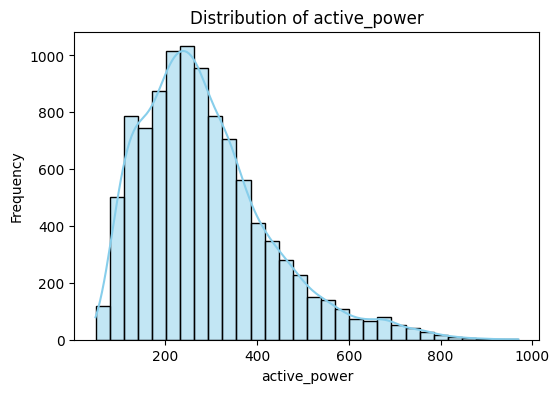

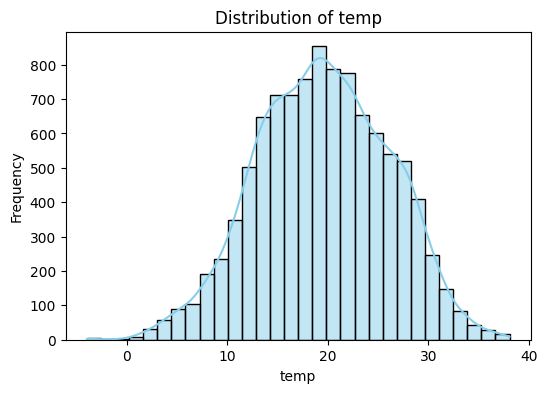

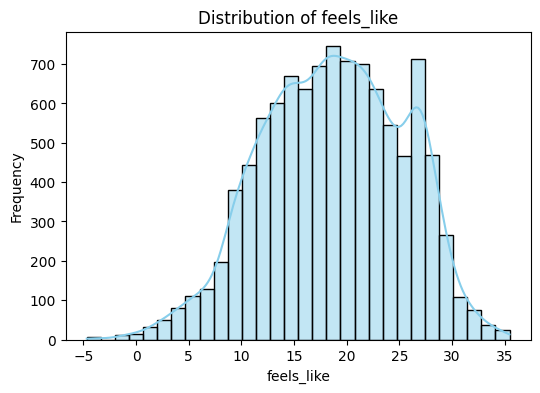

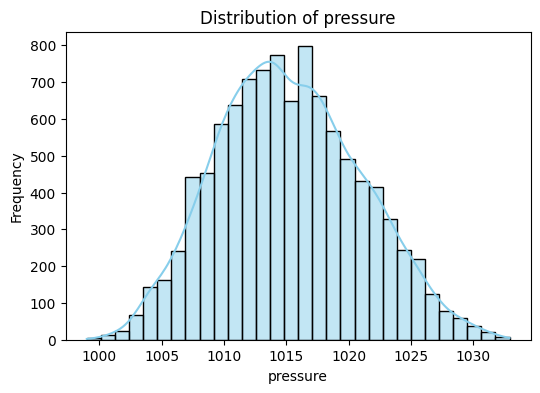

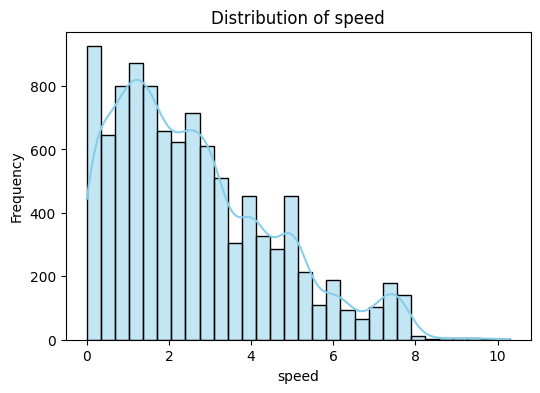

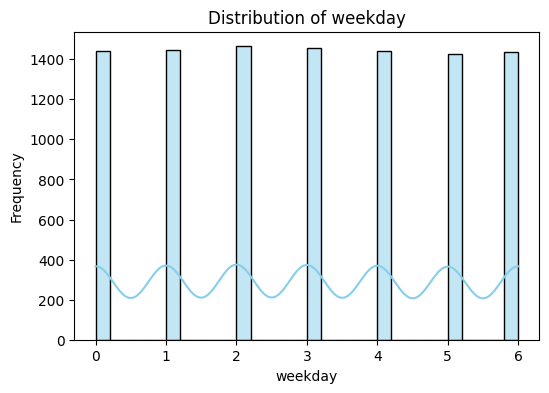

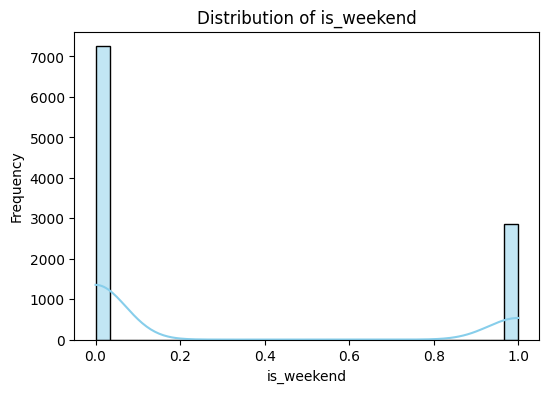

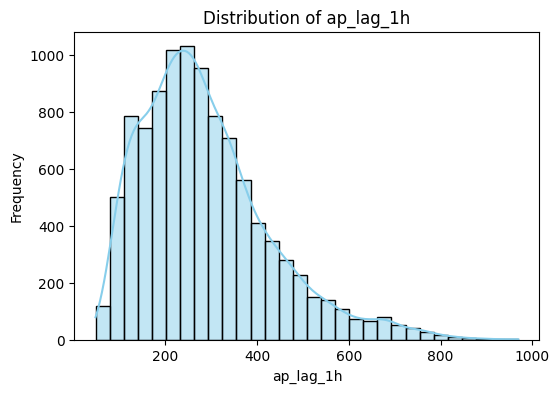

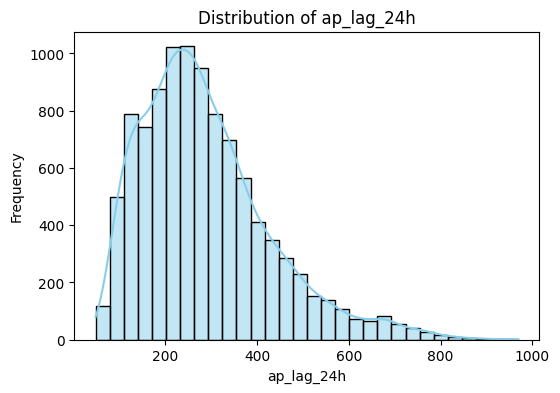

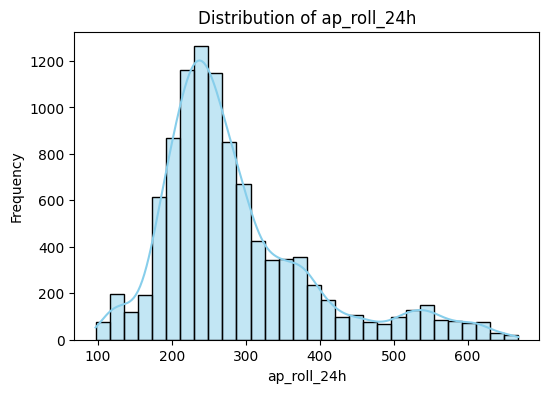

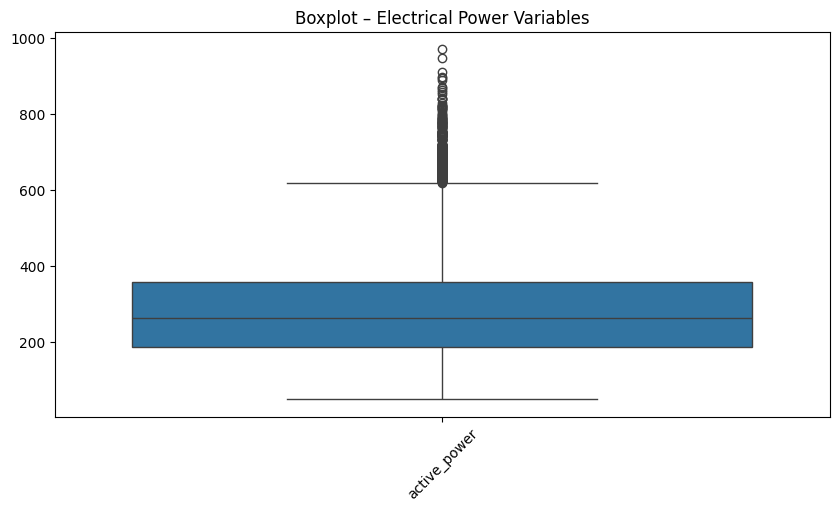

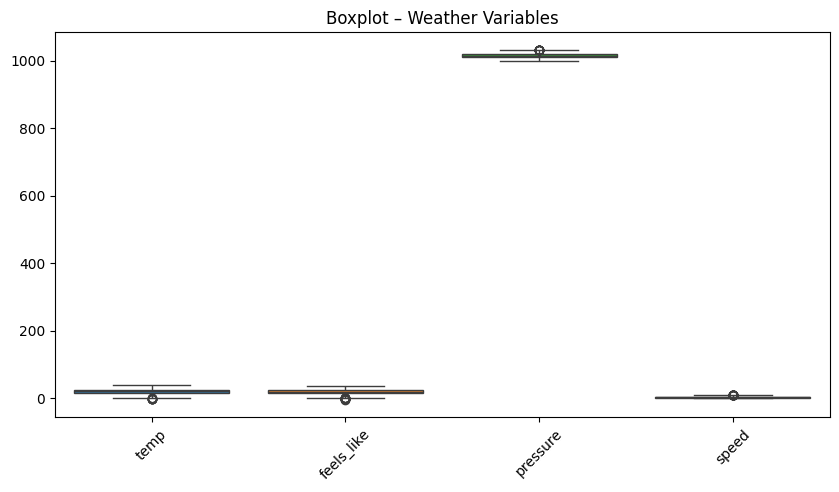

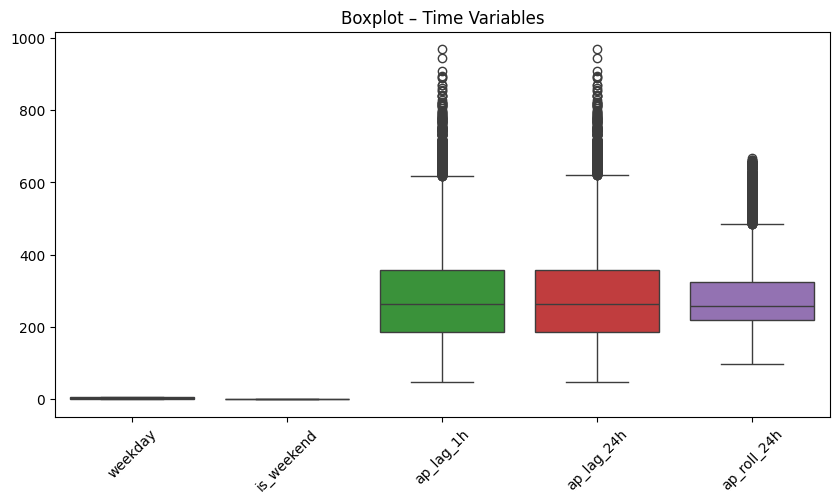

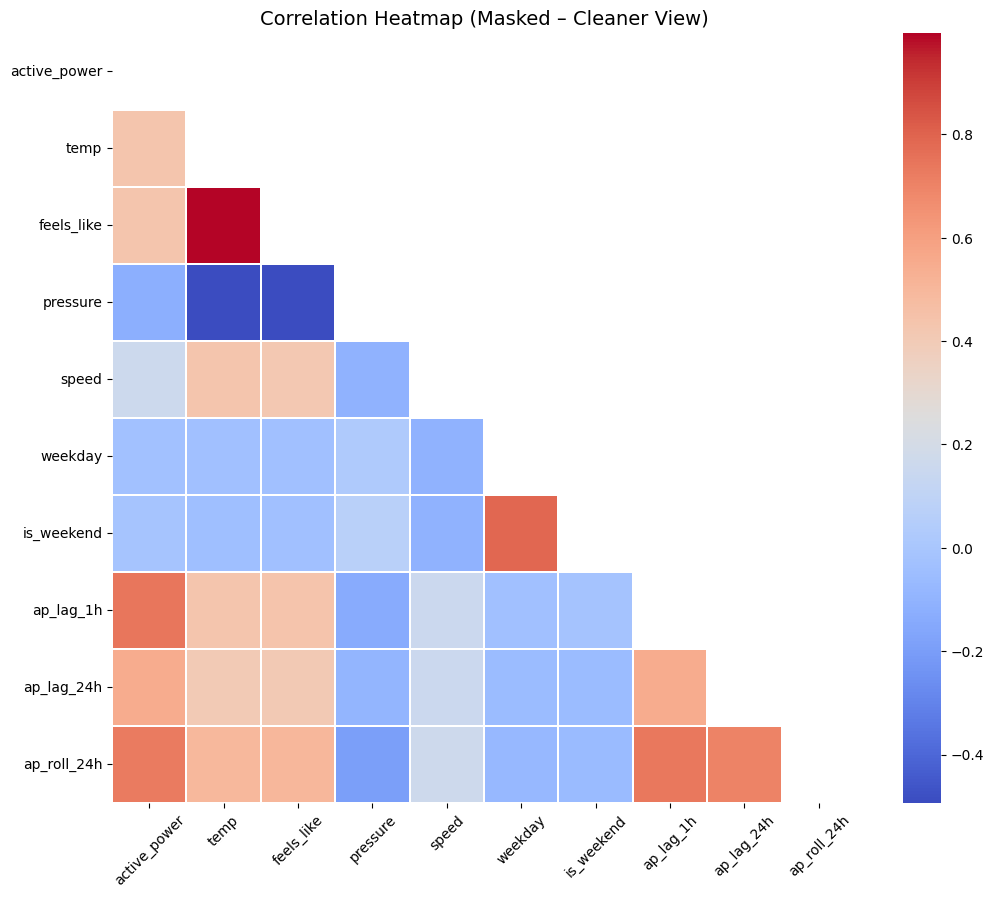

In [8]:

# Choose numeric columns for analysis
num_cols = ['active_power', 'temp', 'feels_like'
            ,'pressure', 'hudmidity', 'speed'
            , 'weekday', 'is_weekend', 'ap_lag_1h', 'ap_lag_24h', 'ap_roll_24h']
num_cols = [c for c in num_cols if c in df_hour.columns]

# Create an empty DataFrame to hold the statistics
stats = pd.DataFrame(index=num_cols, columns=[
    'count', 'mean', 'std', 'min', 'Q1', 'median', 'Q3', 'max',
    'CV(%)', 'Skewness', 'Kurtosis'
])

for col in num_cols:
    data = df_hour[col].dropna()
    stats.loc[col, 'count'] = data.count()
    stats.loc[col, 'mean'] = data.mean()
    stats.loc[col, 'std'] = data.std()
    stats.loc[col, 'min'] = data.min()
    stats.loc[col, 'Q1'] = data.quantile(0.25)
    stats.loc[col, 'median'] = data.median()
    stats.loc[col, 'Q3'] = data.quantile(0.75)
    stats.loc[col, 'max'] = data.max()
    stats.loc[col, 'CV(%)'] = (data.std() / data.mean()) * 100
    stats.loc[col, 'Skewness'] = skew(data)
    stats.loc[col, 'Kurtosis'] = kurtosis(data)

# Round the statistics for better readability
stats = stats.astype(float).round(3)

# Show the descriptive statistics table
print("=== (Descriptive Statistics) ===")
display(stats)

# Data Visualization
# Histogram + KDE
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df_hour[col], bins=30, kde=True, color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Boxplot

#Power variables
power_vars = ['active_power']

plt.figure(figsize=(10,5))
sns.boxplot(data=df_hour[power_vars])
plt.title("Boxplot – Electrical Power Variables")
plt.xticks(rotation=45)
plt.show()

# Weather variables
weather_vars = ['temp','feels_like','pressure','speed']

plt.figure(figsize=(10,5))
sns.boxplot(data=df_hour[weather_vars])
plt.title("Boxplot – Weather Variables")
plt.xticks(rotation=45)
plt.show()

#  Time-derived variables
time_vars = ['weekday','is_weekend','ap_lag_1h','ap_lag_24h','ap_roll_24h']

plt.figure(figsize=(10,5))
sns.boxplot(data=df_hour[time_vars])
plt.title("Boxplot – Time Variables")
plt.xticks(rotation=45)
plt.show()



# Correlation heatmap
corr = df_hour[num_cols].corr()

plt.figure(figsize=(12,10))

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, 
            mask=mask, 
            cmap='coolwarm', 
            linewidths=0.3,
            annot=False)

plt.title("Correlation Heatmap (Masked – Cleaner View)", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()



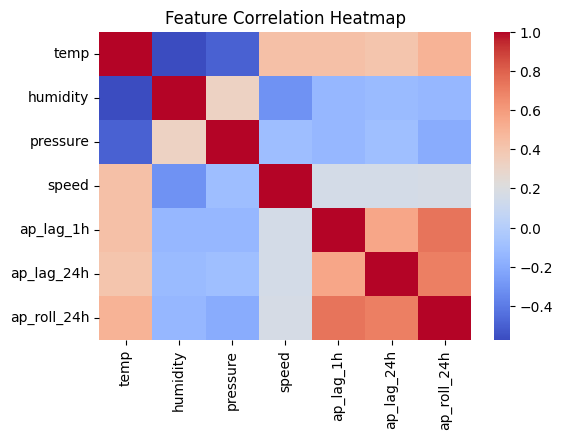

Random Forest CV → MAE=77.1789, RMSE=99.6262, R²=0.2948


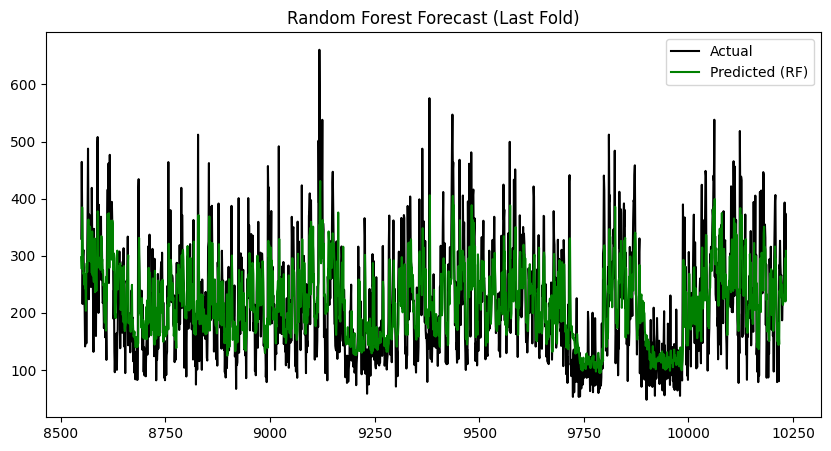

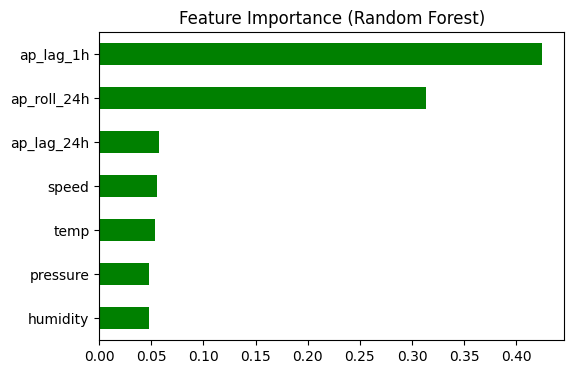

In [9]:


# ========================
# 1. Data preparation
# ========================

features = ['temp','humidity','pressure','speed',
            'ap_lag_1h','ap_lag_24h','ap_roll_24h']

X_rf = df_hour[features].fillna(method='bfill')
y_rf = df_hour['active_power']

# ========================
# 2. Check feature correlations
# ========================

plt.figure(figsize=(6,4))
sns.heatmap(X_rf.corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


# ========================
# 3. TimeSeries Cross-Validation
# ========================

tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

maes, rmses, r2s = [], [], []
last_test_idx = None
last_preds = None

for train_idx, test_idx in tscv.split(X_rf):
    # Train
    rf.fit(X_rf.iloc[train_idx], y_rf.iloc[train_idx])
    
    # Predict
    preds = rf.predict(X_rf.iloc[test_idx])

    # Save scores
    maes.append(mean_absolute_error(y_rf.iloc[test_idx], preds))
    rmses.append(np.sqrt(mean_squared_error(y_rf.iloc[test_idx], preds)))
    r2s.append(r2_score(y_rf.iloc[test_idx], preds))

    last_test_idx = test_idx
    last_preds = preds


print(f"Random Forest CV → MAE={np.mean(maes):.4f}, RMSE={np.mean(rmses):.4f}, R²={np.mean(r2s):.4f}")


# ========================
# 4. Plot Last Fold Prediction
# ========================

plt.figure(figsize=(10,5))
plt.plot(y_rf.iloc[last_test_idx].index, y_rf.iloc[last_test_idx].values,
         label='Actual', color='black')
plt.plot(y_rf.iloc[last_test_idx].index, last_preds,
         label='Predicted (RF)', color='green')

plt.legend()
plt.title("Random Forest Forecast (Last Fold)")
plt.show()


# ========================
# 5. Feature Importance
# ========================

imp = pd.Series(rf.feature_importances_, index=features).sort_values()

plt.figure(figsize=(6,4))
imp.plot(kind='barh', color='green')
plt.title("Feature Importance (Random Forest)")
plt.show()
